###  Bank Churn 

Análisis de datos correspondientes a los clientes de una tarjeta de crédito de un banco para predecir, mediante el uso de técnicas de Aprendizaje Supervisado,  aquellos clientes con mayor propensión a cancelar la tarjeta de crédito del banco, lo que se conoce como Churn. Es decir, predecir el valor de la columna Attrition_Flag.

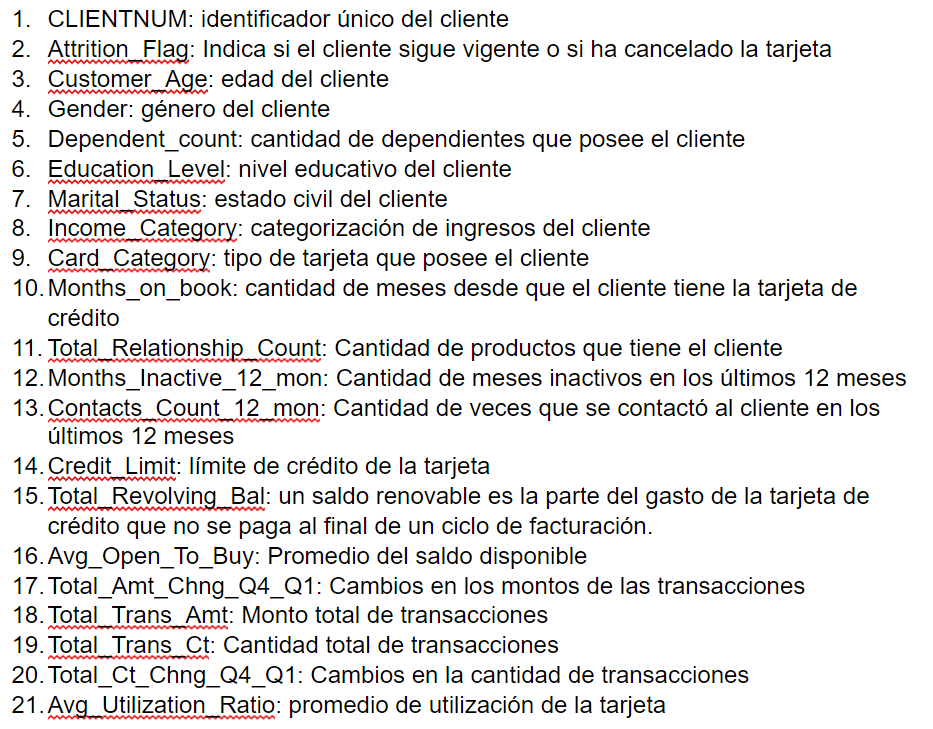

Importación de librerías a utilizar

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [2]:
df = pd.read_csv('BankChurners.csv')

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
class Nans(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        col_nan = x.replace('Unknown', np.nan)
        for i in col_nan.columns.to_list():
            col_nan.loc[col_nan[col_nan[i].isnull()][i].index, i] = np.random.choice(col_nan[col_nan[i].notnull()][i])
        return col_nan

In [5]:
mapper_income = {'Less than $40K':1 ,  '$40K - $60K':2, '$60K - $80K':3, '$80K - $120K':4,  '$120K +':5}
mapper_gender = {'M':0 ,  'F':1}
mapper_education = {'Uneducated':1 ,  'High School':2, 'College':3, 'Graduate':4,  'Post-Graduate':5, 'Doctorate':6}

class mapper_transformer (BaseEstimator, TransformerMixin):
    def __init__(self,mapper):
        self.mapper=mapper

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        col_mapped = x.replace(self.mapper)
        return col_mapped

In [6]:
def drop_columns(column, df):
    df = df.drop(column, axis=1)
    return df

In [7]:
def drop_outliers(df, umbral=3):
    # outliers
    lista_income = ['Less than $40K', '$40K - $60K', '$60K - $80K']
    Q1 = df.Credit_Limit.quantile(0.25)
    Q3 = df.Credit_Limit.quantile(0.75)
    IQR = Q3 - Q1
    umbral_outlier = IQR * umbral
    df = df.drop(df[(df['Credit_Limit'] == 34516.000) & (df['Income_Category'].isin(lista_income))].index)
    return df

In [10]:
def fig_analysis(titulo, name, column, split=None):
    plt.figure(figsize=(12, 7))
    sns.displot(column)
    plt.title(titulo, fontsize=12)
    #plt.savefig(name)
    if split == 'Attrition_Flag':
        plt.figure(figsize=(8, 8))
        sns.displot(data=df, x=column, hue=df.Attrition_Flag)
        plt.title(titulo, fontsize=12)
        plt.xticks(rotation=45)
        #plt.savefig(name)

In [11]:
def dataset_split():
    df.Attrition_Flag = df.Attrition_Flag.replace({'Existing Customer': 1, 'Attrited Customer': 0})
    X = df.drop('Attrition_Flag', axis=1)
    y = df.Attrition_Flag
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
    return X_train, X_test, y_train, y_test

In [46]:
def grid_search(modelo, pipe, params):
    grid = GridSearchCV(pipe, param_grid=params)
    grid.fit(X_train, y_train)
    grid.score(X_train, y_train)
    print('\n', modelo)
    print('\n', str(grid.best_estimator_)[2310:], '\n')
    print('------------------------------------------------------------------------------------')
    return grid.best_estimator_

In [60]:
def cross_validation(modelos):
    fprlist = []
    tprlist = []
    compare_models = {}

    for i in range(0, len(modelos)):
        modelo = modelos[i]
        modelo_pipe = make_pipeline(preprocesador, SMOTE(sampling_strategy=0.5), modelo)
        fold = KFold(n_splits=4, random_state=1, shuffle=True)
        scores = cross_validate(modelo_pipe,
                                X_train,
                                y_train,
                                scoring=metricas,
                                cv=fold,
                                n_jobs=-1)

        modelo_pipe.fit(X_train, y_train) #entrena el modelo ya preprocesado para poder hacer la roc despues
        probs = modelo_pipe.predict_proba(X_train)
        probs = probs[:, 1]
        fpr, tpr, umbral = roc_curve(y_train, probs)
        fprlist.append(fpr)
        tprlist.append(tpr)
        
        compare_models[modelo] = {
        "Accuracy": round(scores['test_accuracy'].mean(), 2),
        "Recall": round(scores['test_recall'].mean(), 2),
        "Precision": round(scores['test_precision'].mean(), 2),
        "F1": round(scores['test_f1'].mean(), 2)}

        df_models = pd.DataFrame([key for key in compare_models.keys()], columns=['Modelo'])
        df_models['Accuracy'] = [value['Accuracy'] for value in compare_models.values()]
        df_models['Recall'] = [value['Recall'] for value in compare_models.values()]
        df_models['Precision'] = [value['Precision'] for value in compare_models.values()]
        df_models['F1'] = [value['F1'] for value in compare_models.values()]
        
        #print('\n', str(modelo), '\n')
        #print('Accuracy:', "%.2f"%scores['test_accuracy'].mean())
        #print('Recall:', "%.2f"%scores['test_recall'].mean())
        #print('Precision:', "%.2f"%scores['test_precision'].mean())
        #print('F1:', "%.2f"%scores['test_f1'].mean())
        #print('------------------------------------------------------------------------------')

    return fprlist, tprlist, df_models

In [14]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(12, 7))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    for i in range(0, len(fpr)):
        plt.plot(fpr[i], tpr[i], label=str(modelos[i])[0:30])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig('ROC_curve.jpg')

# Implementación

Eliminación de columnas innecesarias

In [15]:
df = drop_columns('CLIENTNUM', df)
df = drop_columns('Avg_Open_To_Buy', df)

Análisis exploratorio de datos base

In [16]:
# ---------------------------------------- EDA----------------------------------------- #
'''Se realizó en primer lugar el análisis de nulos, asignándole a las variables categóricas (que 
son las que tienen valores Unknown) un valor en forma aleatoria, dicho valor se encuentra 
dentro del set de datos. Luego se realizó el análisis de outliers y las distribuciones multi y 
univariada de las variables de mayor interés.'''

# ------------------- aplicado con Pipeline ------------------------ #
'''Aplicación de pipeline para tratamiento de nulos'''
preprocesadorNan = make_column_transformer(
                    (Nans(), ['Education_Level',
                              'Marital_Status',
                              'Income_Category']),
                    remainder='passthrough'
                     )

In [17]:
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [18]:
df = pd.DataFrame(preprocesadorNan.fit_transform(df), columns=['Education_Level','Marital_Status','Income_Category',
                                                                 'Attrition_Flag', 'Customer_Age', 'Gender',
                                                                 'Dependent_count','Card_Category', 'Months_on_book',
                                                                 'Total_Relationship_Count', 'Months_Inactive_12_mon',
                                                                 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                                                                 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                                                                 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'
                                                                ])

In [19]:
df = drop_outliers(df)

<ipython-input-10-5a25dcee12e2>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 8))


<Figure size 864x504 with 0 Axes>

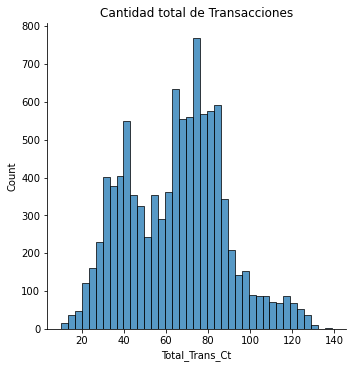

<Figure size 864x504 with 0 Axes>

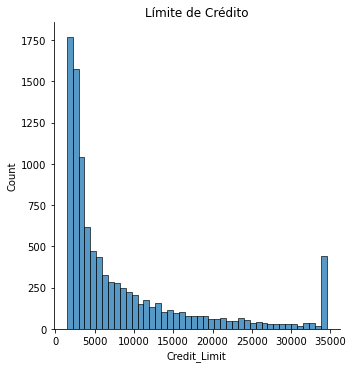

<Figure size 864x504 with 0 Axes>

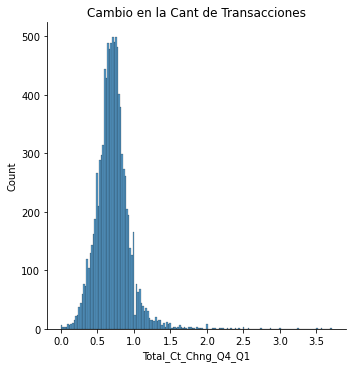

<Figure size 864x504 with 0 Axes>

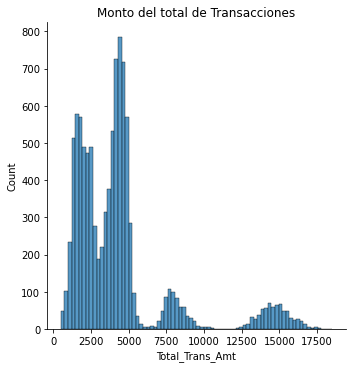

<Figure size 864x504 with 0 Axes>

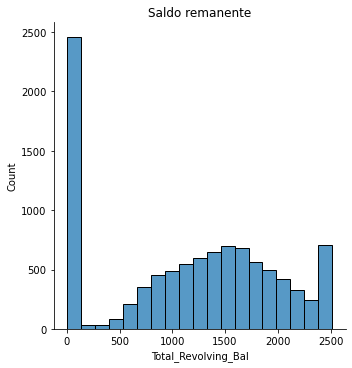

<Figure size 864x504 with 0 Axes>

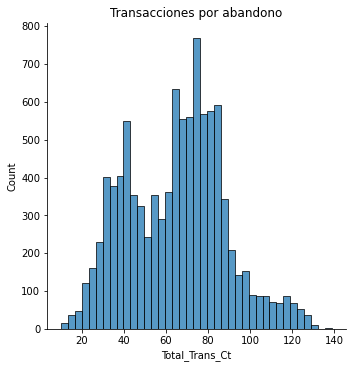

<Figure size 576x576 with 0 Axes>

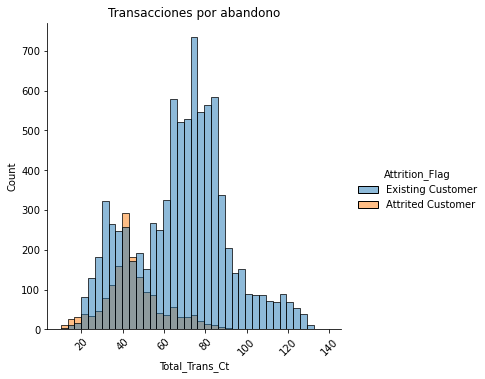

<Figure size 864x504 with 0 Axes>

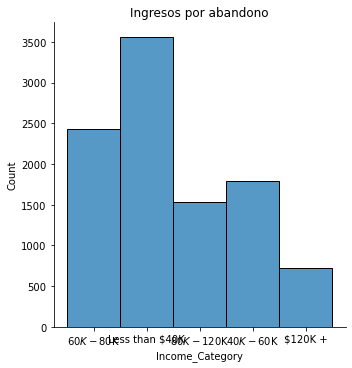

<Figure size 576x576 with 0 Axes>

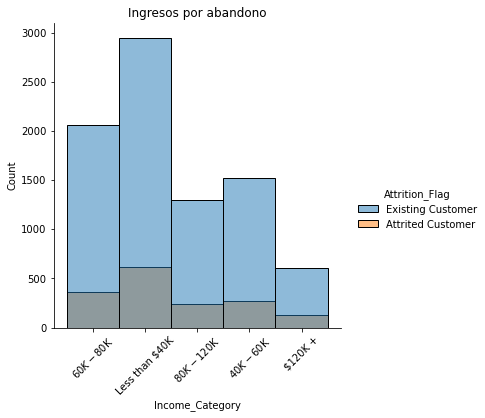

<Figure size 864x504 with 0 Axes>

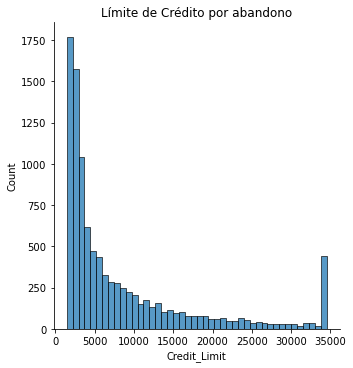

<Figure size 576x576 with 0 Axes>

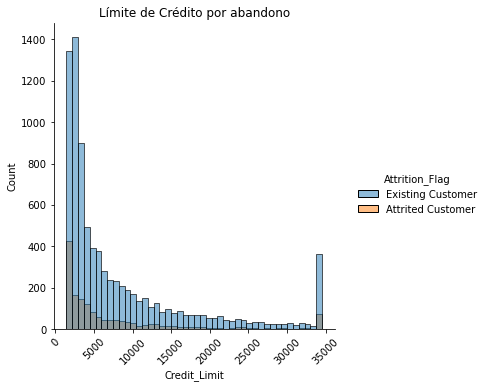

<Figure size 864x504 with 0 Axes>

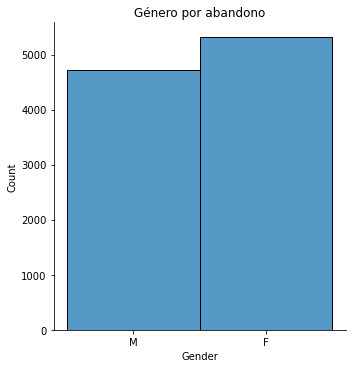

<Figure size 576x576 with 0 Axes>

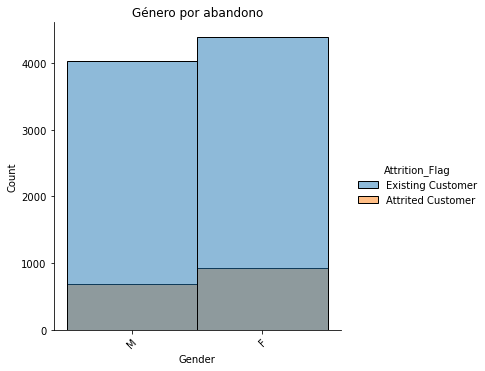

In [20]:
# ----------------------------- Análisis univariado y multivariado ------------------- #
fig_analysis('Cantidad total de Transacciones', 'transacciones.jpg', df.Total_Trans_Ct)
fig_analysis('Límite de Crédito', 'credito.jpg', df.Credit_Limit)
fig_analysis('Cambio en la Cant de Transacciones', 'transaccionescambio.jpg', df.Total_Ct_Chng_Q4_Q1)
fig_analysis('Monto del total de Transacciones', 'transaccionesmonto.jpg', df.Total_Trans_Amt)
fig_analysis('Saldo remanente', 'saldo.jpg', df.Total_Revolving_Bal)
fig_analysis('Transacciones por abandono', 'transaccionesabandono.jpg', df.Total_Trans_Ct, 'Attrition_Flag')
fig_analysis('Ingresos por abandono', 'ingresosabandono.jpg', df.Income_Category, 'Attrition_Flag')
fig_analysis('Límite de Crédito por abandono', 'creditoabandono.jpg', df.Credit_Limit, 'Attrition_Flag')
fig_analysis('Género por abandono', 'generoabandono.jpg', df.Gender, 'Attrition_Flag')

División en set de prueba y set de entrenamiento

In [21]:
# ---------------------------- División en set de TRAIN y TEST ------------------------------------- #
'''Como paso posterior, se realiza la división TRAIN, TEST del set de datos(75 y 25% respectivamente)
y luego, el preprocesamiento de las variables categóricas.'''
X_train, X_test, y_train, y_test = dataset_split()

Preprocesador de columnas individuales

Se analizan las variables categóricas y se realiza escalamiento. El sampleo para tratar el desbalance se realiza dentro del pipeline, entre el preprocesador y la aplicación del modelo

In [22]:
# ----------------------------------- Pipeline preprocesamiento--------------------------------------- #
'''Aplicación de pipeline para tratamiento de variables categóricas (OneHoteEncoder y LabelEncoding)
y escalamiento de variables numéricas'''
preprocesador = make_column_transformer(
                (OneHotEncoder(), ['Marital_Status', 'Card_Category']),
                (mapper_transformer(mapper_gender),['Gender']),
                (mapper_transformer(mapper_income),['Income_Category']),
                (mapper_transformer(mapper_education),['Education_Level']),
                (StandardScaler(), ['Credit_Limit',
                                    'Total_Revolving_Bal',
                                    'Total_Trans_Amt']),
                remainder='passthrough'
            )

Grid Search

Implementación mediante la creación de un pipeline y parámetros correspondientes para cada modelo a evaluar

In [23]:
DT_pipeline = make_pipeline(preprocesador, SMOTE(sampling_strategy=0.5), DecisionTreeClassifier())
DT_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
             'decisiontreeclassifier__max_depth': [5, 7, 9, 10, 11, 13]}

LR_pipeline = make_pipeline(preprocesador, SMOTE(sampling_strategy=0.5), LogisticRegression())
LR_params = {'logisticregression__solver': ['newton-cg', 'liblinear'],  # 'lbfgs','sag','saga'
             'logisticregression__C': [0.1, 1]}

KNN_pipeline = make_pipeline(preprocesador, SMOTE(sampling_strategy=0.5), KNeighborsClassifier())
KNN_params = {'kneighborsclassifier__n_neighbors': [2, 3, 5],
              'kneighborsclassifier__weights': ['uniform', 'distance'],
              'kneighborsclassifier__metric': ['euclidean', 'manhattan']}

RF_pipeline = make_pipeline(preprocesador, SMOTE(sampling_strategy=0.5), RandomForestClassifier())
RF_params = {'randomforestclassifier__n_estimators': [20, 30, 50],
             'randomforestclassifier__max_features': ['auto', 'sqrt'],
             'randomforestclassifier__max_depth': [3, 5, 6],
             'randomforestclassifier__min_samples_leaf': [1, 2]}

SVM_pipeline = make_pipeline(preprocesador, SMOTE(sampling_strategy=0.5), SVC())
SVM_params = {'svc__C': [0.1, 1],
              'svc__gamma': [1, 0.01],
              'svc__kernel': ['rbf'],
              'svc__probability': [True]}

In [47]:
print('GridSearch. Mejores parámetros de cada modelo:\n')

modelos = [grid_search('Decision Tree',DT_pipeline, DT_params), 
           grid_search('Logistic Regression',LR_pipeline, LR_params),
           grid_search('K Nearest Neighbor',KNN_pipeline, KNN_params),
           grid_search('Random Forest',RF_pipeline, RF_params),
           grid_search('Support Vector Machine',SVM_pipeline, SVM_params)]

GridSearch. Mejores parámetros de cada modelo:


 Decision Tree

               DecisionTreeClassifier(criterion='entropy', max_depth=11))]) 

------------------------------------------------------------------------------------

 Logistic Regression

 TE(sampling_strategy=0.5)),
                ('logisticregression',
                 LogisticRegression(C=0.1, solver='liblinear'))]) 

------------------------------------------------------------------------------------

 K Nearest Neighbor

             KNeighborsClassifier(metric='manhattan', n_neighbors=3,
                                      weights='distance'))]) 

------------------------------------------------------------------------------------

 Random Forest

                     min_samples_leaf=2, n_estimators=50))]) 

------------------------------------------------------------------------------------

 Support Vector Machine

                    'Total_Trans_Amt'])])),
                ('smote', SMOTE(sampling_strategy=0.5)

Cross Validation

In [61]:
modelos = [ DecisionTreeClassifier(criterion='entropy', max_depth=11),
            LogisticRegression(C=1, solver='newton-cg'),
            KNeighborsClassifier(metric='manhattan'),
            RandomForestClassifier(max_depth=6, min_samples_leaf=2, n_estimators=30),
          ]

In [64]:
# ----------------------------------- Cross Validation --------------------------------------- #
''''Aplicación de KFlod con 4 carpetas al TRAIN para verificar cuál modelo tiene mejores métricas
antes de decidir entrenarlo.'''
metricas = ['accuracy', 'recall', 'precision', 'f1']
print('Cross Validation. Métricas de cada modelo en el TRAIN:\n')
fpr_list, tpr_list, modelosf = cross_validation(modelos)
modelosf

Cross Validation. Métricas de cada modelo en el TRAIN:



,Modelo,Accuracy,Recall,Precision,F1
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.94,0.96,0.97,0.96
1,"LogisticRegression(C=1, solver='newton-cg')",0.89,0.92,0.95,0.93
2,KNeighborsClassifier(metric='manhattan'),0.87,0.90,0.94,0.92
3,"(DecisionTreeClassifier(max_depth=6, max_featu...",0.94,0.97,0.95,0.96


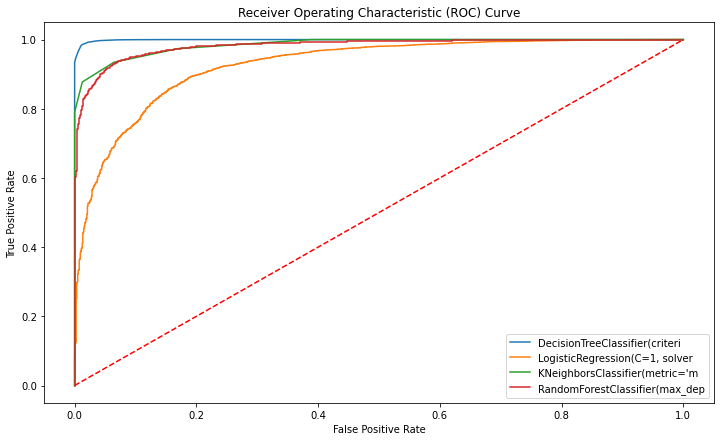

In [65]:
# ROC curve
'''Luego de determinar cuales son los mejores parámetros con GrisSearch y de verificar cuál 
modelo tiene mejor desempeño con Cross Validation (K-Folds), se procede a hacer la curva ROC 
para complemetar el análisis de kfold y poder seleccionar el mejor modelo antes de tomar la 
decisión de entrenarlo.'''
plot_roc_curve(fpr_list, tpr_list)

## Modelo seleccionado

In [90]:
# ------------------------------ Entrenamiento de modelo elegido ------------------------------ #
'''Se seleccionó el modelo del árbol de decisión por ser el de mayor F1, mayor accuracy y por 
tener un alto valor de recall. A su vez, decidimos seleccionarlo, ya que en comparación con RF 
(el cual también presenta valores aceptables) posee menor costo computacional. Un último punto 
que influyó fue la curva ROC, esta se acerca a 1 sin producir overfitting'''
#model_tree = grid_search('Decision Tree',DT_pipeline, DT_params)
model_tree = DecisionTreeClassifier(criterion='entropy', max_depth=11)
X_train_transform = pd.DataFrame(preprocesador.transform(X_train))
X_test_transform = pd.DataFrame(preprocesador.transform(X_test))
model_tree.fit(X_train_transform,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=11)

In [93]:
# ------------------------------ Predicciones y métricas ------ ------------------------------ #
print('Métricas del modelo Decision Tree. Set de TEST\n')
y_pred = model_tree.predict(X_test_transform)
print('Matriz de confusión:\n', confusion_matrix(y_test, y_pred),'\n--------------------------------------\n')

print('Accuracy Score : ',"%.2f"%accuracy_score(y_test, y_pred))
print('Precision Score : ', "%.2f"%precision_score(y_test, y_pred))
print('Recall Score : ', "%.2f"%recall_score(y_test, y_pred))
print('F1 Score : ', "%.2f"%f1_score(y_test, y_pred))
print('---------------------------------------------------------------------------')

Métricas del modelo Decision Tree. Set de TEST

Matriz de confusión:
 [[ 344   76]
 [  69 2021]] 
--------------------------------------

Accuracy Score :  0.94
Precision Score :  0.96
Recall Score :  0.97
F1 Score :  0.97
---------------------------------------------------------------------------


Explainability

Se mide que tan importante es cada atributo para la predicción, con esto podremos observar las variables que mas importancia tienen y su correlación. A modo de prueba tomamos solo las primeras 20 observaciones para que sea más rápido el procesamiento. 

In [69]:
import shap

In [92]:
explainer = shap.KernelExplainer(model_tree.predict, X_test_transform)

Using 2510 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [95]:
shap_values = explainer.shap_values(X_test_transform.iloc[:20,:])

  0%|          | 0/20 [00:00<?, ?it/s]

In [97]:
X_test_transform.columns=['Marital_Status_0',
                     'Marital_Status_1',
                     'Marital_Status_2',
                     'Card_Cat_0',
                     'Card_Cat_1',
                     'Card_Cat_2',
                     'Card_Cat_3',
                     'Gender',
                     'Income',
                     'Education_Level',
                     'Credit_Limit',
                     'Total_Revolving_Bal',
                     'Total_Trans_Amt',
                     'Customer_Age',   
                     'Dependent_count',
                     'Months_on_book',
                     'Total_Relationship_Count',
                     'Months_Inactive_12_mon',
                     'Contacts_Count_12_mon',
                     'Total_Amt_Chng_Q4_Q1',
                     'Total_Trans_Ct',
                     'Total_Ct_Chng_Q4_Q1',
                     'Avg_Utilization_Ratio']

En este grafico se puede observar como esta tomando las decisiones nuestro modelo. Las variables que tienen mayor impacto a la hora de decidir si una persona va a dar de baja la tarjeta o no son las 5 primeras, ya que las restantes, a partir de estas, casi no se despegan del 0, es decir, no son significativas. Se puede observar que, por ejemplo, para cantidades elevadas de transacciones, variable Total_Trans_ct, tiende al 1, o sea, la persona no va a dar de baja la tarjeta.

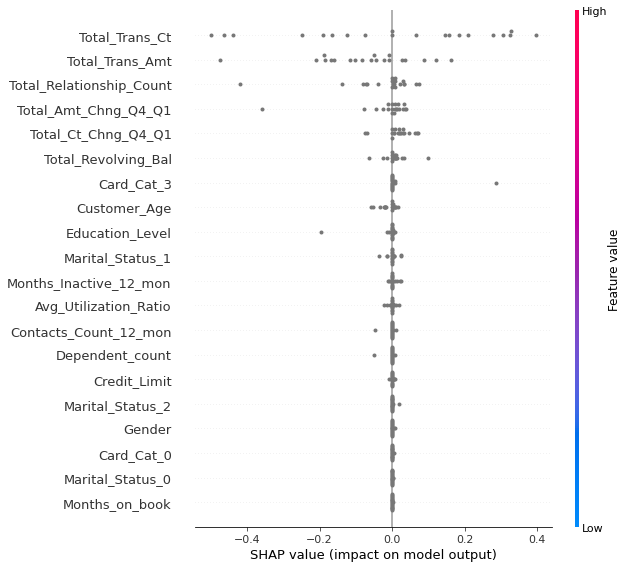

In [98]:
shap.summary_plot(shap_values, X_test_transform.iloc[:20, :])

Se procede a efectuar la interpretacion de 2 casos particulares y, porque el modelo esta prediciendo de esta manera. El primer caso se trata de una persona que va a abandonar la tarjeta, mientras que en el segundo caso sucede lo contrario. 

In [108]:
X_test_transform.iloc[3,:]

Marital_Status_0                 0.0
Marital_Status_1                 1.0
Marital_Status_2                 0.0
Card_Cat_0                       1.0
Card_Cat_1                       0.0
Card_Cat_2                       0.0
Card_Cat_3                       0.0
Gender                             1
Income                             1
Education_Level                    1
Credit_Limit                0.119234
Total_Revolving_Bal        -1.432981
Total_Trans_Amt             1.372961
Customer_Age                      41
Dependent_count                    3
Months_on_book                    30
Total_Relationship_Count           1
Months_Inactive_12_mon             2
Contacts_Count_12_mon              3
Total_Amt_Chng_Q4_Q1           1.056
Total_Trans_Ct                    51
Total_Ct_Chng_Q4_Q1            1.684
Avg_Utilization_Ratio            0.0
Name: 3, dtype: object

In [107]:
pd.DataFrame(y_test).iloc[3,:] #Abandona la tarjeta

Attrition_Flag    0
Name: 9977, dtype: int64

En este caso la prediccion es 0, es decir, da de baja la tarjeta y, como se puede observar las variables que tiran para abajo la prediccion, es decir al 0, son la cantidad de transacciones que es baja, el Total_Revolving_Bal y los cambios en la cantidad de transacciones que tambien son infimos.

In [101]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[12], X_test_transform.iloc[12,:])

In [102]:
X_test_transform.iloc[4,:]

Marital_Status_0                 0.0
Marital_Status_1                 0.0
Marital_Status_2                 1.0
Card_Cat_0                       1.0
Card_Cat_1                       0.0
Card_Cat_2                       0.0
Card_Cat_3                       0.0
Gender                             0
Income                             3
Education_Level                    2
Credit_Limit               -0.775675
Total_Revolving_Bal        -0.247981
Total_Trans_Amt             0.138264
Customer_Age                      55
Dependent_count                    3
Months_on_book                    47
Total_Relationship_Count           3
Months_Inactive_12_mon             2
Contacts_Count_12_mon              2
Total_Amt_Chng_Q4_Q1           0.834
Total_Trans_Ct                    97
Total_Ct_Chng_Q4_Q1            0.764
Avg_Utilization_Ratio            0.6
Name: 4, dtype: object

In [106]:
pd.DataFrame(y_test).iloc[4,:] #No da de baja la tarjeta

Attrition_Flag    1
Name: 7356, dtype: int64

En este caso la prediccion es 1, es decir, no da de baja la tarjeta y, como se puede observar las variables que tienden a dicha prediccion son el saldo renovable alto, la alta cantidad de productos y el Total_Ct_Chng_Q4_Q1 tambien es elevado.

In [109]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4], X_test_transform.iloc[4,:])